1. IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

from google_play_scraper import reviews, Sort
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

2. SCRAPPING DATA

In [2]:
def get_reviews(app_id, n=1000):
    result = []
    count = 0
    while count < n:
        new_reviews, _ = reviews(app_id, lang='id', country='id', sort=Sort.NEWEST, count=200)
        result.extend(new_reviews)
        count = len(result)
    df = pd.DataFrame(result)[['userName', 'score', 'at', 'content']]
    return df

df_shopee = get_reviews("com.shopee.id", 1000)
df_tokopedia = get_reviews("com.tokopedia.tkpd", 1000)

# Simpan data mentah
df_shopee.to_csv('../data/raw/shopee_raw.csv', index=False)
df_tokopedia.to_csv('../data/raw/tokopedia_raw.csv', index=False)

3. PREPROCESSING

In [3]:
stemmer = StemmerFactory().create_stemmer()
stop_remover = StopWordRemoverFactory().create_stop_word_remover()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = stop_remover.remove(text)
    text = stemmer.stem(text)
    return text

4. SENTIMENT ANALYSIS(VADER)

In [4]:
sid = SentimentIntensityAnalyzer()

def sentiment_analysis(df):
    df['clean'] = df['content'].apply(clean_text)
    df['sentiment_score'] = df['clean'].apply(lambda x: sid.polarity_scores(x)['compound'])
    df['sentiment'] = df['sentiment_score'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
    return df

df_shopee = sentiment_analysis(df_shopee)
df_tokopedia = sentiment_analysis(df_tokopedia)

5. VISUALISASI SENTIMEN

C:\Users\ACER\AppData\Local\Temp\ipykernel_6708\428469029.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette='Set2')


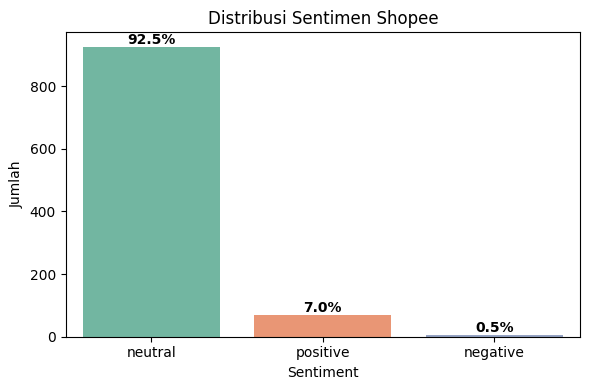

C:\Users\ACER\AppData\Local\Temp\ipykernel_6708\428469029.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette='Set2')


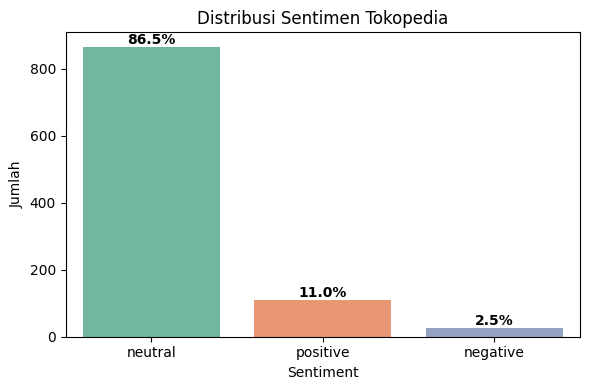

In [5]:
def plot_sentiment(df, title):
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='sentiment', data=df, palette='Set2')
    
    # Hitung total dan tampilkan persentase pada tiap bar
    total = len(df)
    for p in ax.patches:
        count = p.get_height()
        percentage = f'{100 * count / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Jumlah')
    plt.tight_layout()
    plt.show()

# Panggil fungsi dengan data Shopee dan Tokopedia
plot_sentiment(df_shopee, "Distribusi Sentimen Shopee")
plot_sentiment(df_tokopedia, "Distribusi Sentimen Tokopedia")


6. WORD CLOUD

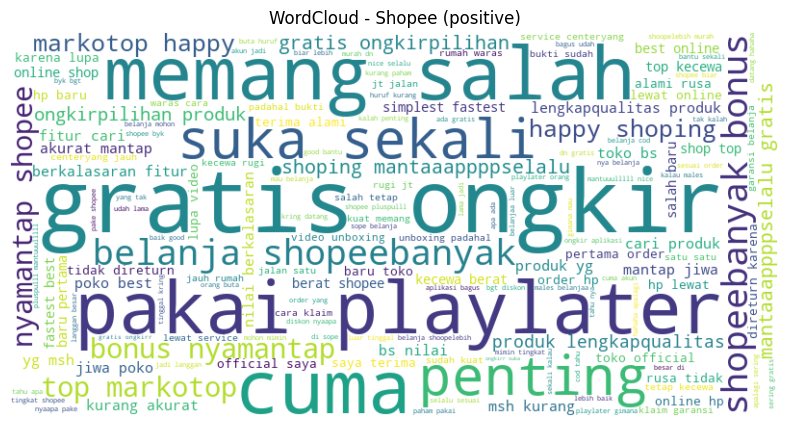

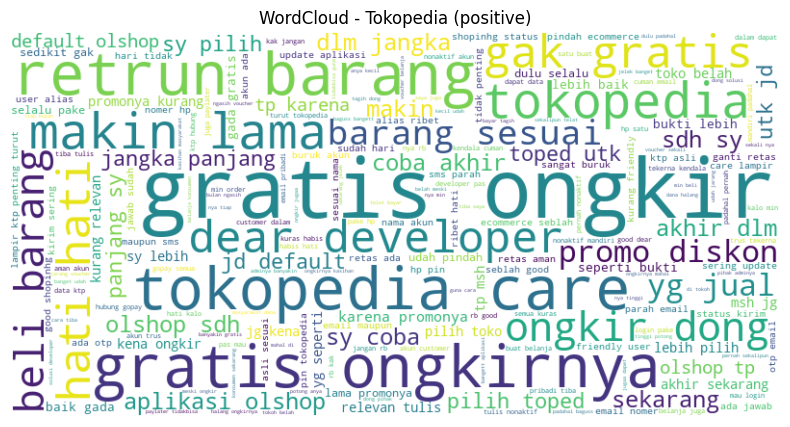

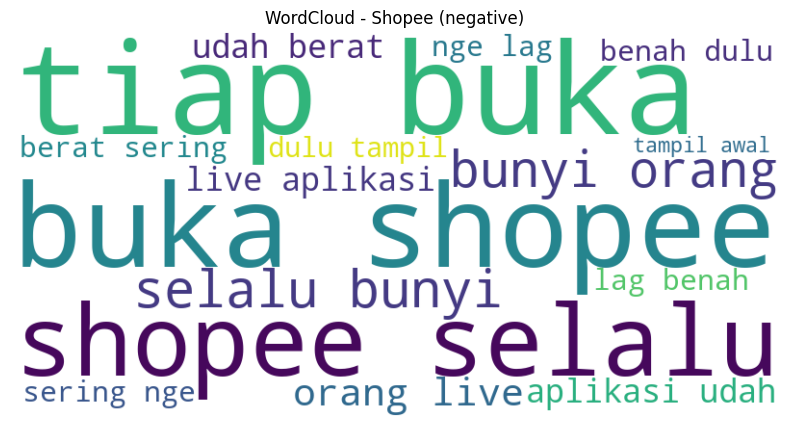

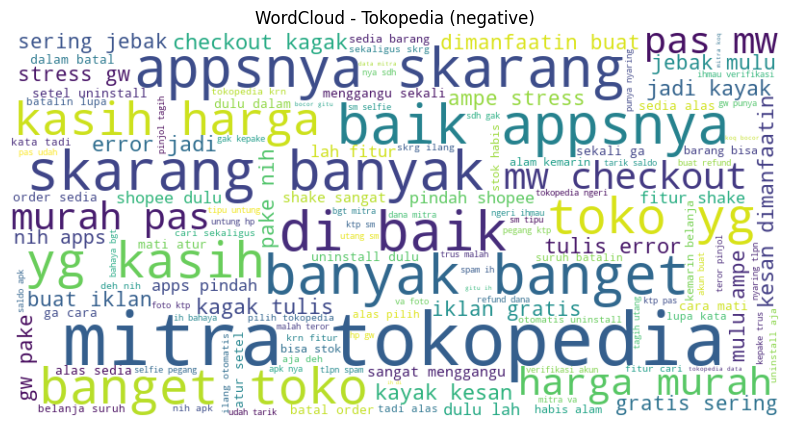

In [6]:
def generate_wordcloud(df, sentiment_label, app_name):
    text = ' '.join(df[df['sentiment'] == sentiment_label]['clean'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - {app_name} ({sentiment_label})')
    plt.show()

generate_wordcloud(df_shopee, 'positive', 'Shopee')
generate_wordcloud(df_tokopedia, 'positive', 'Tokopedia')
generate_wordcloud(df_shopee, 'negative', 'Shopee')
generate_wordcloud(df_tokopedia, 'negative', 'Tokopedia')

7. NAIVE BAYES CLASSIFIER

In [7]:
def run_naive_bayes(df, app_name):
    df = df[df['sentiment'] != 'neutral']
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df['clean'])
    y = df['sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nNaive Bayes - {app_name}")
    print("Akurasi:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

run_naive_bayes(df_shopee, "Shopee")
run_naive_bayes(df_tokopedia, "Tokopedia")


Naive Bayes - Shopee
Akurasi: 1.0
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         1
    positive       1.00      1.00      1.00        14

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15


Naive Bayes - Tokopedia
Akurasi: 1.0
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        10
    positive       1.00      1.00      1.00        17

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



8. CLUSTERING (KMEANS + PCA)

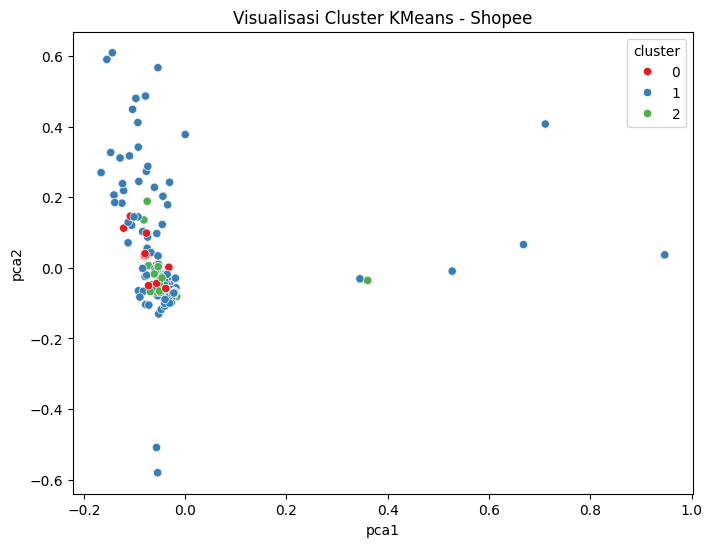

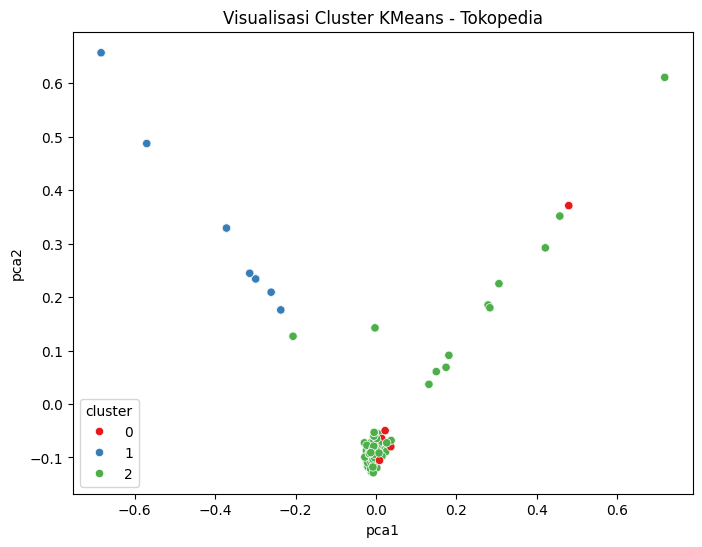

In [8]:
def run_kmeans(df, app_name):
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df['clean'])
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(X)

    pca = PCA(n_components=2)
    components = pca.fit_transform(X.toarray())
    df['pca1'] = components[:, 0]
    df['pca2'] = components[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='Set1')
    plt.title(f'Visualisasi Cluster KMeans - {app_name}')
    plt.show()

run_kmeans(df_shopee, "Shopee")
run_kmeans(df_tokopedia, "Tokopedia")

9. SIMPAN DATASET FINAL

In [9]:
df_shopee.to_csv("../data/processed/shopee_final.csv", index=False)
df_tokopedia.to_csv("../data/processed/tokopedia_final.csv", index=False)